In [1]:
import os
data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

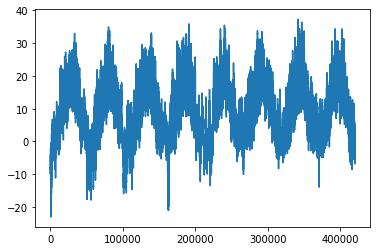

In [3]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] #温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)
plt.show()

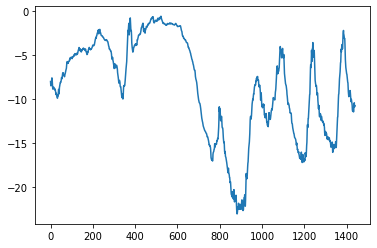

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def genereator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index+lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index +lookback
            rows = np.array(i, min(i+batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### 准备训练生成器，验证生成器，和测试生成器

#### 准备更高分辨率的数据生成器

In [9]:
lookback= 720
step = 3
delay = 144

train_gen = genereator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = genereator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      shuffle=True,
                      step=step)

train_gen = genereator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      shuffle=True,
                      step=step)

val_steps = (300000 - 200001 - lookback) //128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [12]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 90s 181ms/step - loss: 0.3179 - val_loss: 0.2930
Epoch 2/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2764 - val_loss: 0.2873
Epoch 3/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2576 - val_loss: 0.2946
Epoch 4/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2419 - val_loss: 0.3021
Epoch 5/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2315 - val_loss: 0.3079
Epoch 6/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2213 - val_loss: 0.3080
Epoch 7/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2137 - val_loss: 0.3188
Epoch 8/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2051 - val_loss: 0.3176
Epoch 9/20
500/500 [==============================] - 89s 178ms/step - loss: 0.1989 - val_loss: 0.33

In [15]:
his_dict = history.history
print(his_dict.keys())

dict_keys(['loss', 'val_loss'])


In [14]:
import matplotlib.pylab as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accurancy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

KeyError: 'acc'